In [1]:
import pydicom
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets

### Getting the affine matrix

In [2]:
patient = 'P5'
image_dir = f'/data/vr_heart/datasets/3D_Lab_Abnormal_Heart/Abnormal_Heart/{patient}/Dicom'
image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
label_path = f'/data/vr_heart/datasets/3D_Lab_Abnormal_Heart/Abnormal_Heart/{patient}/{patient}_labels.nii.gz'
output_dir = '/home/sharan/VR-Heart-Workspace/VR-Heart-PG/outputs/3D_Lab'

In [3]:
nifti_label = nib.load(label_path)
label_affine = nifti_label.affine
print(label_affine)

[[  -0.41015601    0.            0.           94.08000183]
 [   0.           -0.41015601    0.          -75.19999695]
 [   0.            0.            0.5        -103.48999786]
 [   0.            0.            0.            1.        ]]


The above affine matrix is not the actual affine matrix that represents the image. It is only the metadata. It may or may not be accurate.<br/>
Moreover changing this .affine attribute won't actually change the actual affine matrix in anyway.

Extracting the affine matrix using SimpleITK

In [4]:
def get_affine_matrix(image_file):
    if not isinstance(image_file, str):
        image = sitk.GetImageFromArray(image_file)
    else:
        image = sitk.ReadImage(image_file)
    
    direction = image.GetDirection()
    spacing = image.GetSpacing()
    origin = image.GetOrigin()

    affine_matrix = np.array([[direction[0] * spacing[0], direction[3] * spacing[1], direction[6] * spacing[2], origin[0]],
                    [direction[1] * spacing[0], direction[4] * spacing[1], direction[7] * spacing[2], origin[1]],
                    [direction[2] * spacing[0], direction[5] * spacing[1], direction[8] * spacing[2], origin[2]],
                    [0, 0, 0, 1]])
    
    return affine_matrix

affine_matrix = get_affine_matrix(image_path)
print(affine_matrix)

[[  0.410156   0.         0.       -94.08    ]
 [  0.         0.410156   0.        75.2     ]
 [  0.         0.         0.5      -40.49    ]
 [  0.         0.         0.         1.      ]]


In [5]:
get_affine_matrix(image_path)

array([[  0.410156,   0.      ,   0.      , -94.08    ],
       [  0.      ,   0.410156,   0.      ,  75.2     ],
       [  0.      ,   0.      ,   0.5     , -40.49    ],
       [  0.      ,   0.      ,   0.      ,   1.      ]])

In [6]:
get_affine_matrix(label_path)

array([[   0.41015601,    0.        ,    0.        ,  -94.08000183],
       [   0.        ,    0.41015601,    0.        ,   75.19999695],
       [   0.        ,    0.        ,    0.5       , -103.48999786],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

### Applying MONAI transforms

In [7]:
from monai.transforms import *

In [8]:
print("Before transformation: \n", get_affine_matrix(image_path))

transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    RandFlip(spatial_axis=0, prob=1.0),
    RandRotate90(spatial_axes=(1, 2), prob=1.0),
    Rand3DElastic(prob=1.0, sigma_range=(5, 8), magnitude_range=(5, 8)),
    ToTensor()
])

trans_image = transforms(image_path)
print("After transformation: \n", get_affine_matrix(trans_image))

Before transformation: 
 [[  0.410156   0.         0.       -94.08    ]
 [  0.         0.410156   0.        75.2     ]
 [  0.         0.         0.5      -40.49    ]
 [  0.         0.         0.         1.      ]]
After transformation: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


### Setting the affine matrix to a custom matrix

In [9]:
import os

import os
import SimpleITK as sitk
import numpy as np

def set_affine_matrix(image_file, target_affine_matrix=None, out_file=None, resample=False, maintain_ref=True):
    if not isinstance(image_file, str):
        image = sitk.GetImageFromArray(image_file)
    else:
        image = sitk.ReadImage(image_file)

    if out_file is None:
        out_file = image_file
    else:
        base_name = os.path.basename(out_file)
        out_file = os.path.join(output_dir, base_name)
        os.makedirs(os.path.dirname(out_file), exist_ok=True)

    img_affine_matrix = get_affine_matrix(image_file)
    print("Before:\n", img_affine_matrix)

    if target_affine_matrix is None:
        def eye_affine(affine_matrix):
            matrix = np.eye(4)
            matrix[:3, 3] = affine_matrix[:3, 3]
            return matrix
        new_affine = eye_affine(img_affine_matrix)
    else:
        new_affine = target_affine_matrix

    if resample:
        reference_image = sitk.Image(image.GetSize(), image.GetPixelIDValue())
        if not maintain_ref:
            reference_image.SetOrigin(new_affine[:3, 3])
        else:
            reference_image.SetOrigin(image.GetOrigin())
        reference_image.SetDirection(new_affine[:3, :3].flatten())
        reference_image.SetSpacing(np.abs(new_affine[:3, :3].diagonal()))
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(reference_image)
        resampler.SetTransform(sitk.Transform())
        resampler.SetInterpolator(sitk.sitkLinear)
        image = resampler.Execute(image)
    else:
        image.SetOrigin(new_affine[:3, 3])
        image.SetDirection(new_affine[:3, :3].flatten())
        image.SetSpacing(new_affine[:3, :3].diagonal())

    sitk.WriteImage(image, out_file)
    return new_affine



img_file = label_path

# For overwriting the current file. UNCOMMENT THIS ONLY IF ABSOLUTELY SURE.
# orig_affine = get_affine_matrix(img_file)
# set_affine_matrix(img_file, orig_affine, resample=True)
# set_affine_matrix(img_file, resample=True)

# For setting the affine matrix to identity matrix and save it to a new file
out_file = os.path.join(output_dir, f"{patient}_labels.nii.gz")
# set_affine_matrix(img_file, out_file=out_file, resample=True)

# For setting the affine matrix to a custom matrix and save it to a new file
custom_affine = np.random.rand(4, 4)
set_affine_matrix(img_file, target_affine_matrix=custom_affine, out_file=out_file, resample=True)

print("After:\n", get_affine_matrix(out_file))

Before:
 [[   0.41015601    0.            0.          -94.08000183]
 [   0.            0.41015601    0.           75.19999695]
 [   0.            0.            0.5        -103.48999786]
 [   0.            0.            0.            1.        ]]
After:
 [[-9.85404973e-02  5.33053172e-01  6.61892330e-01 -9.40800018e+01]
 [ 1.24706213e-01  7.76000734e-01 -1.83871670e-01  7.51999969e+01]
 [ 1.36237392e-01 -3.24762359e-01  6.47055396e-01 -1.03489998e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


NiftiImageIO (0x558245fb6800): Non-orthogonal direction matrix coerced to orthogonal



torch.Size([1, 512, 512, 317])
torch.Size([1, 512, 512, 317])
2871336.0


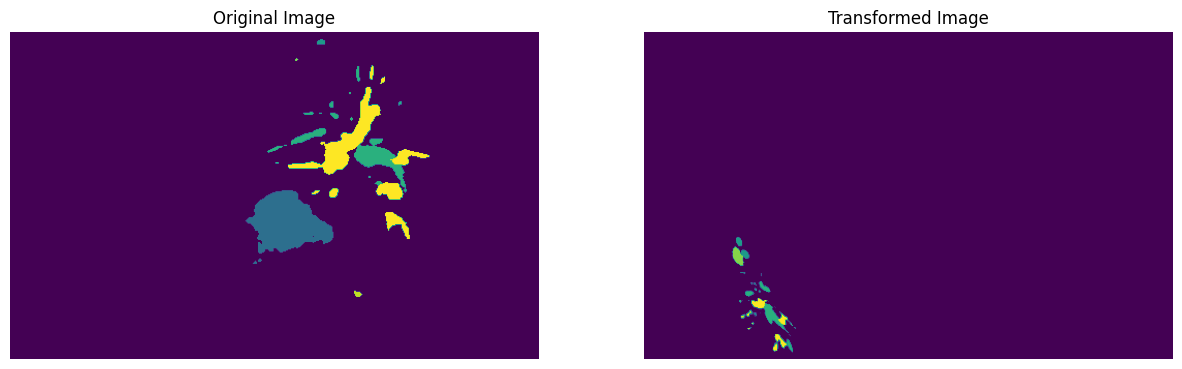

In [10]:
transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ToTensor()])

orig_img = transforms(img_file)
orig_img_np = orig_img
print(orig_img_np.shape)
trans_img = transforms(out_file)
trans_img_np = trans_img
print(trans_img_np.shape)
print(np.sum(trans_img_np))

slice_index = 180
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

if trans_img_np.ndim == 4:
    ax[0].imshow(np.rot90(orig_img_np[0, slice_index, :, :]))
    ax[1].imshow(np.rot90(trans_img_np[0, slice_index, :, :]))
else:
    ax[0].imshow(np.rot90(orig_img_np[slice_index, :, :]))
    ax[1].imshow(np.rot90(trans_img_np[slice_index, :, :]))

ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].axis('off')
ax[1].set_title('Transformed Image')
plt.show()